# Dont' use features that require transform to res variables with celmech in tseries. Almost as good as models that include them

In [16]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [17]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "aucpr", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-aucpr-mean"])
    error = np.mean(score["test-aucpr-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    precision, recall, thresh = metrics.precision_recall_curve(testY, preds)
    test_score = metrics.auc(recall, precision)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

resparamfeatures = ['betanear', 'jnear', 'strengthnear', 'C_AMDnear', 'reshalfwidthnear', 'betafar',
                   'jfar', 'strengthfar', 'C_AMDfar', 'reshalfwidthfar', 'betaouter',
                    'secondres', 'reshalfwidthouter', 'jouter', 'C_AMDouter']
tseriesfeatures = ['EMcrossnear', 'EMcrossfar', 'EMcrossouter', 'strengthouter', 
       'tlyap', 'megno', 'EMmednear', 'EMmaxnear', 'EMstdnear', 'EMslopenear', 'EMrollingstdnear',
       'EPmednear', 'EPmaxnear', 'EPstdnear', 'EPslopenear', 'EProllingstdnear', 'EMmedfar', 'EMmaxfar',
       'EMstdfar', 'EMslopefar', 'EMrollingstdfar', 'EPmedfar', 'EPmaxfar', 'EPstdfar', 'EPslopefar',
       'EProllingstdfar', 'EMmedouter', 'EMmaxouter', 'EMstdouter', 'AMDerr',
       'EMslopeouter', 'EMrollingstdouter', 'EPmedouter', 'EPmaxouter',
       'EPstdouter', 'EPslopeouter', 'EProllingstdouter']

features = resparamfeatures + tseriesfeatures

datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'


In [18]:
listNorbits=[1e4]
for Norbits in listNorbits:
    featurefolder = 'ressummaryfeaturesxgbv6Norbits{0:.1f}Nout1000/'.format(Norbits)
    trainingdatafolder = datapath+dset+featurefolder
    trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)


    dtrain = xgb.DMatrix(trainX, trainY)
    dtest = xgb.DMatrix(testX, testY)

    trials = Trials()
    best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)

    best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                             learning_rate = best["x_learning_rate"], 
                             max_depth = int(best["x_max_depth"]), 
                             min_child_weight = best["x_min_child"],
                             subsample = best["x_subsample"], 
                             colsample_bytree = best["x_tree_colsample"])
    params = best_xgbc.get_xgb_params()
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "aucpr", verbose_eval=True)
    d_Train = xgb.DMatrix(trainX, trainY)
    d_Test = xgb.DMatrix(testX)
    bst = xgb.train(params, d_Train)
    preds = bst.predict(d_Test)
    score = metrics.average_precision_score(testY, preds)

    model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                             learning_rate = best["x_learning_rate"], 
                             max_depth = int(best["x_max_depth"]), 
                             min_child_weight = best["x_min_child"],
                             subsample = best["x_subsample"], 
                             colsample_bytree = best["x_tree_colsample"])

    model.fit(trainX, trainY, eval_metric='aucpr')

    dill.dump([model, features, featurefolder], open(datapath+"../models/ressummaryfeaturesxgbv6_resonant{0:.0e}.pkl".format(Norbits), "wb"))

SCORE:                                              
0.82806458                                          
ERROR                                               
0.010704535070100586                                
HOLDOUT SCORE                                       
0.8774092572473715                                  
SCORE:                                                                        
0.8213314800000001                                                            
ERROR                                                                         
0.011091784116416491                                                          
HOLDOUT SCORE                                                                 
0.8660995562530867                                                            
SCORE:                                                                        
0.8369695600000002                                                            
ERROR                                             

0.011366185511581334                                                           
HOLDOUT SCORE                                                                  
0.8630866053210126                                                             
SCORE:                                                                         
0.82733642                                                                     
ERROR                                                                          
0.010199572773488302                                                           
HOLDOUT SCORE                                                                  
0.8702189876460995                                                             
SCORE:                                                                         
0.56557474                                                                     
ERROR                                                                          
0.028921336482871755                    

0.012339128161321069                                                           
HOLDOUT SCORE                                                                  
0.883415907442142                                                              
SCORE:                                                                         
0.8352968199999999                                                             
ERROR                                                                          
0.010398022053643787                                                           
HOLDOUT SCORE                                                                  
0.8811970256832944                                                             
SCORE:                                                                         
0.7194008799999999                                                             
ERROR                                                                          
0.014707298674670943                    

Text(0.5, 1.0, 'ROC curve (AUC = 0.959)')

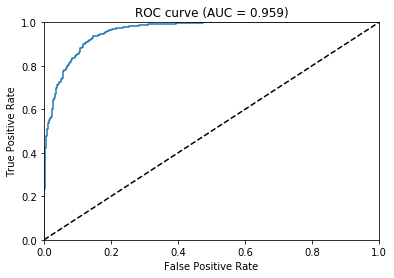

In [22]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [23]:
for i in range(0,len(fpr), 15):
    print("Threshold {0}, FPR = {1}, TPR = {2}".format(rocthresholds[i], fpr[i], tpr[i]))

Threshold 1.9999017715454102, FPR = 0.0, TPR = 0.0
Threshold 0.9860304594039917, FPR = 0.00411240575736806, TPR = 0.3844731977818854
Threshold 0.9591091871261597, FPR = 0.01028101439342015, TPR = 0.512014787430684
Threshold 0.9424808025360107, FPR = 0.018505825908156272, TPR = 0.5582255083179297
Threshold 0.9128478765487671, FPR = 0.025359835503769704, TPR = 0.6284658040665434
Threshold 0.8827143907546997, FPR = 0.033584647018505824, TPR = 0.6691312384473198
Threshold 0.8439748883247375, FPR = 0.03906785469499657, TPR = 0.7079482439926063
Threshold 0.8000836372375488, FPR = 0.04934886908841672, TPR = 0.7264325323475046
Threshold 0.7116411328315735, FPR = 0.06442769019876628, TPR = 0.7837338262476895
Threshold 0.6079264283180237, FPR = 0.07539410555174778, TPR = 0.8133086876155268
Threshold 0.5018351078033447, FPR = 0.08978752570253598, TPR = 0.8373382624768947
Threshold 0.4287303388118744, FPR = 0.10212474297464016, TPR = 0.8539741219963032
Threshold 0.3341927230358124, FPR = 0.1151473

In [100]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.0025387408677488565, recall = 1.0, precision = 0.43876723438767234
Threshold 0.002793877152726054, recall = 0.9981515711645101, precision = 0.4433497536945813
Threshold 0.0033131123054772615, recall = 0.9981515711645101, precision = 0.4488778054862843
Threshold 0.0036996505223214626, recall = 0.9981515711645101, precision = 0.45454545454545453
Threshold 0.004002034198492765, recall = 0.9981515711645101, precision = 0.46035805626598464
Threshold 0.004368775989860296, recall = 0.9981515711645101, precision = 0.46632124352331605
Threshold 0.005086724646389484, recall = 0.9981515711645101, precision = 0.47244094488188976
Threshold 0.005759655963629484, recall = 0.9963031423290203, precision = 0.4778368794326241
Threshold 0.0063275182619690895, recall = 0.9944547134935305, precision = 0.4833782569631626
Threshold 0.006997937336564064, recall = 0.9944547134935305, precision = 0.4899817850637523
Threshold 0.007695464417338371, recall = 0.9944547134935305, precision = 0.49676823638

In [55]:
i=400
PRthreshold = PRthresholds[i]
rec = recall[i]
prec = precision[i]
print(PRthreshold, rec, prec)

0.06322314 0.9704251386321626 0.6302521008403361


In [86]:
trainX, trainy, testX, testy = train_test_split(trainingdatafolder, features, filter=False)
preds = model.predict_proba(testX)[:,1]

In [87]:
predy = (preds >= PRthreshold)

In [88]:
predlabels[:10]

array([False, False, False, False, False, False, False, False,  True,
        True])

In [89]:
testy[:10]

7999     True
8000    False
8001    False
8002    False
8003     True
8004    False
8005    False
8006     True
8007    False
8008    False
Name: Stable, dtype: bool

In [120]:
np.linspace(0,1,N)

array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
       0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
       0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
       0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
       0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
       0.07007007, 0.07107107, 0.07207207, 0.07307307, 0.07407

In [126]:
predy = (preds >= 0)
tn, fp, fn, tp = confusion_matrix(testy, predy).ravel()
tn, fp, fn, tp

(0, 1459, 0, 541)

In [128]:
npv[np.isnan(npv)] = 1

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

N=1000
npv, tnr = np.zeros(N), np.zeros(N)
ppv, tpr = np.zeros(N), np.zeros(N)
for i, thresh in enumerate(np.linspace(0, 1, N)):
    predy = (preds >= thresh)
    tn, fp, fn, tp = confusion_matrix(testy, predy).ravel()
    ppv[i] = tp/(tp+fp)
    tpr[i] = tp/(tp+fn)
    npv[i] = tn/(tn+fn)
    tnr[i] = tn/(tn+fp)
    
# When thresh is 0 or 1, we don't predict any of one class, so ppv and npv can be nan (conditioned on predicted pos or neg)
ppv[np.isnan(ppv)] = 1
npv[np.isnan(npv)] = 1
#tpr[np.isnan(tpr)] = 1
#tnr[np.isnan(tnr)] = 1

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [91]:
pp = tp+fp
pp

833

In [92]:
prec = tp/pp
prec

0.6302521008403361

In [93]:
p = tp+fn
rec = tp/p
rec

0.9704251386321626

In [116]:
for i in range(0,len(rec), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], rec[i], prec[i]))

Threshold 0.0025387408677488565, recall = 1.0, precision = 0.43876723438767234
Threshold 0.002793877152726054, recall = 0.9981515711645101, precision = 0.4433497536945813
Threshold 0.0033131123054772615, recall = 0.9981515711645101, precision = 0.4488778054862843
Threshold 0.0036996505223214626, recall = 0.9981515711645101, precision = 0.45454545454545453
Threshold 0.004002034198492765, recall = 0.9981515711645101, precision = 0.46035805626598464
Threshold 0.004368775989860296, recall = 0.9981515711645101, precision = 0.46632124352331605
Threshold 0.005086724646389484, recall = 0.9981515711645101, precision = 0.47244094488188976
Threshold 0.005759655963629484, recall = 0.9963031423290203, precision = 0.4778368794326241
Threshold 0.0063275182619690895, recall = 0.9944547134935305, precision = 0.4833782569631626
Threshold 0.006997937336564064, recall = 0.9944547134935305, precision = 0.4899817850637523
Threshold 0.007695464417338371, recall = 0.9944547134935305, precision = 0.49676823638

IndexError: index 1245 is out of bounds for axis 0 with size 1232

In [118]:
for i in range(0,len(rec), 15):
    print("Threshold {0}, tnr = {1}, npv = {2}".format(PRthresholds[i], tnr[i], npv[i]))

Threshold 0.0025387408677488565, tnr = 0.5257025359835503, npv = 1.0
Threshold 0.002793877152726054, tnr = 0.5352981494174092, npv = 0.9987212276214834
Threshold 0.0033131123054772615, tnr = 0.5455791638108294, npv = 0.998745294855709
Threshold 0.0036996505223214626, tnr = 0.5558601782042495, npv = 0.9987684729064039
Threshold 0.004002034198492765, tnr = 0.5661411925976696, npv = 0.9987908101571947
Threshold 0.004368775989860296, tnr = 0.5764222069910898, npv = 0.998812351543943
Threshold 0.005086724646389484, tnr = 0.5867032213845099, npv = 0.9988331388564761
Threshold 0.005759655963629484, tnr = 0.5962988348183688, npv = 0.9977064220183486
Threshold 0.0063275182619690895, tnr = 0.6058944482522276, npv = 0.9966178128523112
Threshold 0.006997937336564064, tnr = 0.6161754626456477, npv = 0.9966740576496674
Threshold 0.007695464417338371, tnr = 0.6264564770390678, npv = 0.9967284623773174
Threshold 0.008507847785949707, tnr = 0.636737491432488, npv = 0.9967811158798283
Threshold 0.009628

IndexError: index 1245 is out of bounds for axis 0 with size 1232

In [125]:
npv

array([       nan, 1.        , 1.        , 0.99872774, 0.99879227,
       0.99882491, 0.99773243, 0.99667774, 0.99674267, 0.99680511,
       0.99684543, 0.99584631, 0.99486125, 0.99490316, 0.99494949,
       0.99498998, 0.99501992, 0.99308983, 0.99315068, 0.99318403,
       0.99323671, 0.99328859, 0.99332698, 0.99239544, 0.99243856,
       0.99245994, 0.99246704, 0.99248826, 0.99158879, 0.99162011,
       0.99165121, 0.9907919 , 0.99085923, 0.99088423, 0.99001815,
       0.99005425, 0.99008115, 0.9901168 , 0.98925694, 0.98926655,
       0.98927614, 0.98928571, 0.98929527, 0.98931434, 0.98933333,
       0.98934281, 0.98937112, 0.98937112, 0.98852604, 0.98854626,
       0.98769772, 0.9877193 , 0.98774081, 0.98777293, 0.98779425,
       0.98695652, 0.98697917, 0.98700173, 0.98701299, 0.98702422,
       0.98703544, 0.98623064, 0.9862543 , 0.98628963, 0.98547009,
       0.98547009, 0.98549488, 0.98550725, 0.98550725, 0.9855565 ,
       0.985581  , 0.98393914, 0.9839527 , 0.98396624, 0.98396

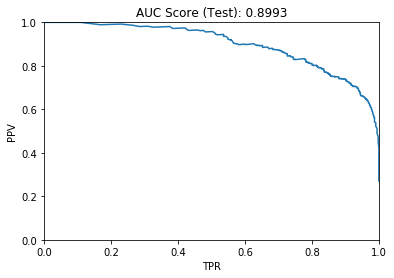

In [134]:
pr_auc = auc(tpr, ppv)
fig, ax = plt.subplots()
ax.plot(tpr, ppv)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('TPR')
ax.set_ylabel('PPV')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

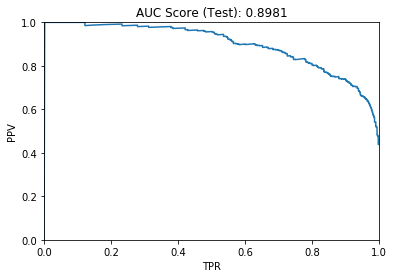

In [107]:
pr_auc = auc(tpr, ppv)
fig, ax = plt.subplots()
ax.plot(tpr, ppv)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('TPR')
ax.set_ylabel('PPV')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

In [115]:
tpr.shape

(1999,)

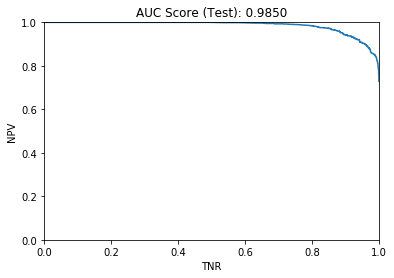

In [135]:
nauc = auc(tnr, npv)
fig, ax = plt.subplots()
ax.plot(tnr, npv)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('TNR')
ax.set_ylabel('NPV')
ax.set_title("AUC Score (Test): {0:.4f}".format(nauc))
plt.show()

(0, 189.20000000000002)

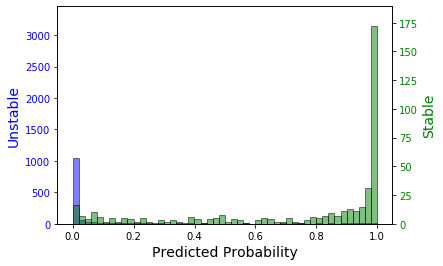

In [10]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

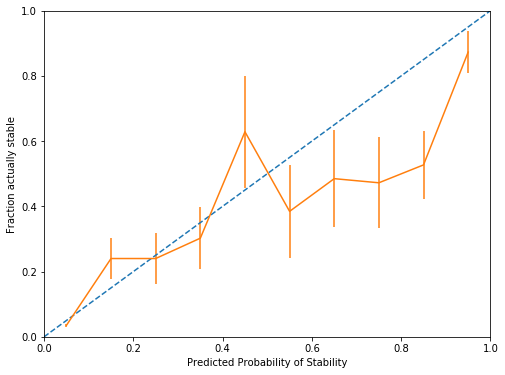

In [11]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

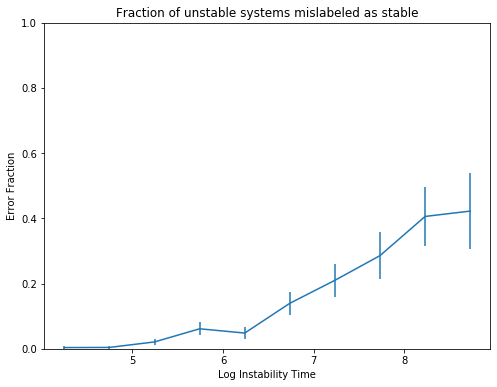

In [24]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

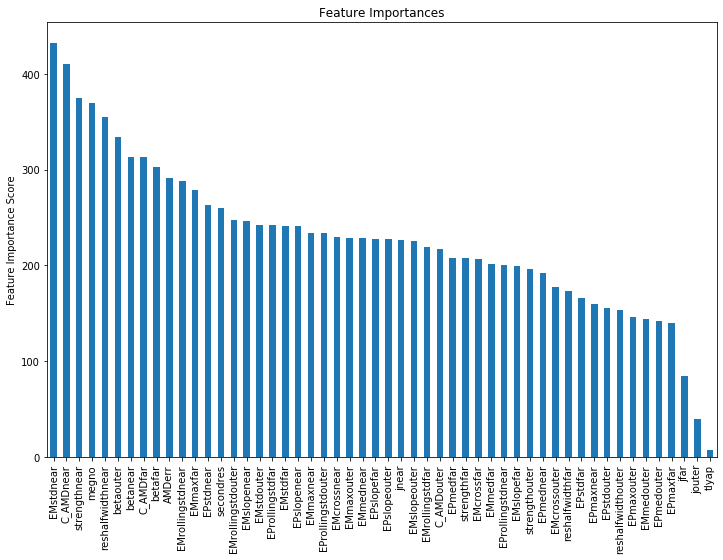

In [13]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# things that are just unstable might be very similar to things that are just stable

# predict at half a billion, then repredict at half a billion whether you'll be unstable at a billion

# do the summary features change with time?

# We care about probability it is unstable when we predict unstable. Look at these errors specifically